# Using Perceptrons and Convolutional Neural Networks To Classify Handwritten Digits



My Nguyen <P>
March 21st, 2023 <P>


This notebook is focused on exploring the application of Neural Networks in classifying images of handwritten digits from the MNIST dataset. Three types of Neural Networks are used for this task: One-layer Perceptrons (OLP), Multi-layer Perceptron (MLP), and Convolutional Perceptron (CNN). Our goal is to compare their performances in order to understand the difference between the three architectures and to determine the suitable architecture for this task. <p>
The results indicate that the performance of CNN outperforms OLP and MLP in classifying images of handwritten digits. The increased complexity of the CNN architecture, with its added convolutional and pooling layers, leads to better accuracy in recognizing the images of handwritten digits. This study highlights the importance of utilizing the appropriate architecture for image recognition tasks. The use of multi-layer neural networks, specifically MLP and CNN, showcases the power of these models in recognizing and classifying images of handwritten digits.

The dataset used in this project is the MNIST dataset. The MNIST dataset is a dataset of handwritten digits which has a training set of 60000 samples, and a test set of 100000 samples. The samples are 28x28 grayscale images of the 10 digits (0 to 9). It is a subset of a larger set from NIST. The digits have been size-normalized and centered in a fixed-size image. <p>
For convenience, all the Neural Networks architectures are implemented using TensorFlow and Keras library. TensorFlow is an open-sourced end-to-end platform, a library for mutiple machine learning tasks. Keras is a high-level neural network library that runs on top of TensorFlow. Matplotlib library is used to visualize data. Numpy library is used for easier data manipulation.

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Dense, Flatten, Dropout, Activation
from sklearn.metrics import confusion_matrix
import seaborn as sns

The data is loaded into the notebook using the Keras library. Both training data and testing data are represented as 3D numpy arrays. The array's shape is (numberOfSamples, height, width). height and width indicate the number of pixels in each dimension of the images. Since the data we are working with is images where values of pixels can range from 0-255, it is recommended to normalize data to a fixed range of 0-1 to ensure that the algorithm is not biased towards features with higher magnitude. Because Perceptron model from Keras only works with 2-D numpy arrays, the original data is reshaped to (numberOfSamples, height x width). height x width indicates the total number of pixels in each image, or the input size.

A sample in the training set: 
Label:  5
Sample: 


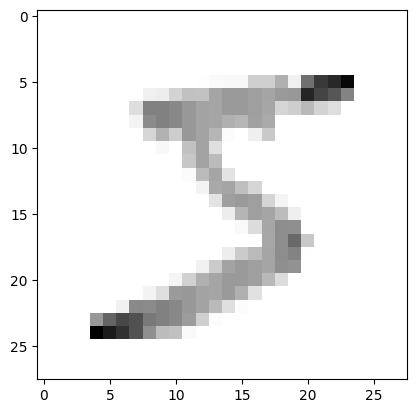

In [ ]:
def preparingData():
  '''
  The function helps us prepare the dataset by loading the
  dataset in the notebook and cleaning the dataset for use.
  The function also displays a sample from the training set
  along with its label.
  PARAMETERS:
  none

  RETURN VALUE: trainingData, testingData, trainingLabels,
                testingLabels, inputSize, imageSize, numClasses
  The function returns two 2-dimensional arrays that are the training
  data and testing data, Two 1-dimensional arrays that are the
  labels of the training data and testing data, inputSize (the number
  of pixels in each sample image, which is 28x28), imageSize (which is 28),
  numClasses (number of classes which are 10 because the digits are from 0
  to 9).
  '''
  #load data
  mnist = tf.keras.datasets.mnist
  (rawTrainingData, trainingLabels), (rawTestingData, testingLabels) = mnist.load_data()

  #normalize data
  processedTrainingData = tf.keras.utils.normalize(rawTrainingData, axis = 1)
  processedTestingData = tf.keras.utils.normalize(rawTestingData, axis = 1)

  #extract useful information
  imageSize = processedTrainingData.shape[1] #square image
  inputSize = imageSize * imageSize
  numClasses = len(np.unique(trainingLabels))

  #reshape data
  trainingData = np.reshape(processedTrainingData, [-1, inputSize])
  testingData = np.reshape(processedTestingData, [-1, inputSize])

  #visualization purpose
  print("A sample in the training set: ")
  print("Label: ", trainingLabels[0])
  print("Sample: ")
  plt.imshow(processedTrainingData[0], cmap = plt.cm.binary)
  plt.show()

  return trainingData, testingData, trainingLabels, testingLabels, inputSize, imageSize, numClasses

trainingData, testingData, trainingLabels, testingLabels, inputSize, imageSize, numClasses = preparingData()

In this code cell below, there are 2 helper functions: makeConfusionMatrix and epoch_plot_loss. <p>
The makeConfusionMatrix makes a confusion matrix based on the target labels and the output labels. A confusion matrix is a table that is often used to evaluate the performance of a classification model by comparing its predicted output against the actual output. A confusion matrix shows the number of true positives, false positives, true negatives, and false negatives, and provides valuable insights into the accuracy and precision of the classification model. The confusion matrix can help us identify which handwritten digits the model tends to struggle with. <p>
The epoch_plot_loss function plots a line graph showing the relationship between the loss value and the number of epoch. In Keras, loss is a measurement indicating the difference between the predicted output of the neural network model and the actual output. It represents the error or cost of the model's prediction. It also tells us how well the neural network model is performing on the training data during the training process. Moreover, if we plot a line graph showing the relationship between the loss value and the number of epoch, we can find the number of optimal number of epochs to train the model using the elbow point technique.

In [ ]:
def makeConfusionMatrix(targetLabels, outputLabels):
  '''
  The function makes a confusion matrix based on the target labels and the output
  labels.
  PARAMETERS:
  outputLabels -  a 1D numpy array contains the labels of the output
  targetLabels -  a 1D numpy array contains the target labels

  RETURN VALUE: none
  '''
  cm = confusion_matrix(targetLabels, outputLabels)

  # plot the confusion matrix using seaborn heatmap
  sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')

  # set the axis labels and title
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()


def epoch_plot_loss(lossValues):
  '''
  The function plots a line graph showing the relationship between the loss value and
  the number of epoch
  PARAMETERS:
  lossValues - a 1D array containing the loss value when training the model using
  different numbers of epochs

  RETURN VALUE: none
  '''
  plt.plot(lossValues)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss for Each Epoch')
  plt.show()

The oneLayerPerceptron function implements the OLP model. The activation function chosen for the output layer is the softmax function. The background information of the softmax function as well as the reasoning for choosing the function is provided in the paper, under the Methodology section. <p>
For the optimization algorithm, Adam optimizer is chosen. Adam is a popular optimization algorithm used for training neural networks, especially for deep learning tasks. It combines ideas from adaptive gradient descent and momentum methods to achieve fast convergence and better generalization performance. <p>
For the loss function, the "sparse_categorical_crossentropy" is chosen. It is commonly used for multi-class classification problems, such as the task of classifying hand-written digits into 10 different categories (0-9). This loss function calculates the cross-entropy loss between the predicted probability distribution and the true labels. <p>
The activation function for the output layer, the optimization algorithm, and the loss function is the same for all three models. <p>

In [ ]:
def oneLayerPerceptron(trainingData, trainingLabels, testingData, testingLabels, inputSize, numClasses, epochsNum):
  '''
  The function implements One-Layer Perceptron.
  PARAMETERS:
  trainingData - a 2D numpy array contains the training samples
  trainingLabels -  a 1D numpy array contains the labels of training samples
  testingData - a 2D numpy array contains the testing samples
  testingLabels -  a 1D numpy array contains the labels of testing samples
  inputSize - an integer value indicating the number of pixels in each image sample
  numClasses - an integer valuendicating the number of classes (1 class for each digit)

  RETURN VALUE: loss, accuracy
  The function returns loss (a scaler value of categorical cross entropy) and accuracy (the
  pecentage of predict values that match with actual values)
  '''
  # Flatten the images to a 1D array to work with One-Layer Perceptron
  trainingData = trainingData.reshape(trainingData.shape[0], -1)
  testingData = testingData.reshape(testingData.shape[0], -1)

  model = Sequential([
    Dense(numClasses, input_shape=(inputSize,), activation='softmax')
  ])
  model.compile(loss = "sparse_categorical_crossentropy", optimizer ="adam", metrics =['accuracy'])
  history = model.fit(trainingData, trainingLabels, epochs=epochsNum, validation_split=0.1)
  epochAccuracy = history.history['accuracy']
  epochLoss = history.history['loss']
  ynew = model.predict(testingData)
  predictLabels = np.argmax(ynew,axis = 1)
  loss, accuracy = model.evaluate(testingData, testingLabels)
  return loss, accuracy, epochLoss, predictLabels

This code cell below runs the model with 15 epochs. The purpose is to get the loss value when training the model with different numbers of epoch. Once the array of loss values is obtained, a line graph showing the relationship between the loss value and the number of epoch can help us determine the optimal number of epoch using the elbow point technique.

Epoch 1/15
1688/1688 [==============================] - 4s 2ms/step - loss: 0.6364 - accuracy: 0.8528 - val_loss: 0.3258 - val_accuracy: 0.9165
Epoch 2/15
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3563 - accuracy: 0.9011 - val_loss: 0.2769 - val_accuracy: 0.9265
Epoch 3/15
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3192 - accuracy: 0.9107 - val_loss: 0.2601 - val_accuracy: 0.9262
Epoch 4/15
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3015 - accuracy: 0.9151 - val_loss: 0.2506 - val_accuracy: 0.9287
Epoch 5/15
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2906 - accuracy: 0.9179 - val_loss: 0.2465 - val_accuracy: 0.9317
Epoch 6/15
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2827 - accuracy: 0.9200 - val_loss: 0.2429 - val_accuracy: 0.9332
Epoch 7/15
1688/1688 [==============================] - 3s 2ms/step - loss: 0.2773 - accuracy: 0.9216 - val_loss: 0.2395 - val_accuracy:

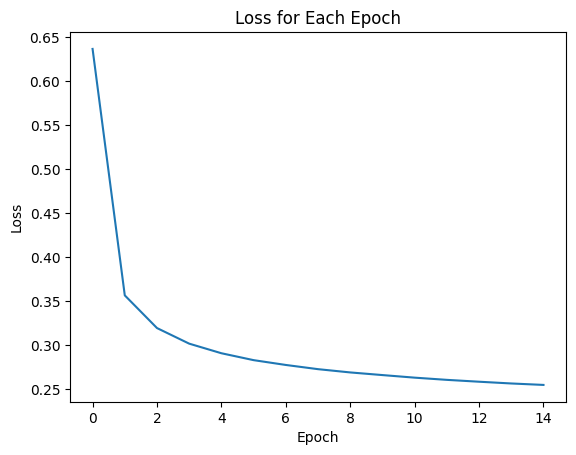

In [ ]:
lossOneLayer, accuracyOneLayer, epochLossOneLayer, predictLabelsOneLayer = oneLayerPerceptron(trainingData, trainingLabels, testingData, testingLabels, inputSize, numClasses, 15)

# Plot epoch loss graph to find optimal number of epoch
epoch_plot_loss(epochLossOneLayer)

Once the optimal number of epoch is determined, the model is trained using this number of epoch. Then, the confusion matrix is made using the predictions of the model.

Epoch 1/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.6386 - accuracy: 0.8511 - val_loss: 0.3263 - val_accuracy: 0.9173
Epoch 2/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3566 - accuracy: 0.9002 - val_loss: 0.2803 - val_accuracy: 0.9207
Epoch 3/5
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3193 - accuracy: 0.9096 - val_loss: 0.2602 - val_accuracy: 0.9280
Epoch 4/5
1688/1688 [==============================] - 3s 2ms/step - loss: 0.3014 - accuracy: 0.9151 - val_loss: 0.2507 - val_accuracy: 0.9292
Epoch 5/5
313/313 [==============================] - 0s 1ms/step - loss: 0.2827 - accuracy: 0.9207


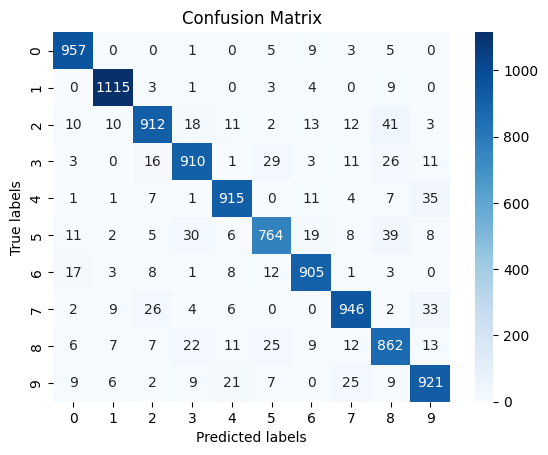

In [ ]:
optimalEpochNumOneLayer = 5
# train the model using the optimal number of epoch
lossOneLayerOptimal, accuracyOneLayerOptimal, epochLossOneLayerOptimal, predictLabelsOneLayerOptimal = oneLayerPerceptron(trainingData, trainingLabels, testingData, testingLabels, inputSize, numClasses, optimalEpochNumOneLayer)

# make confusion matrix based on the predictions of One Layer Perceptron
makeConfusionMatrix(testingLabels, predictLabelsOneLayerOptimal)


The multiLayerPerceptron function implements the MLP model. The activation function chosen for the output layer is the softmax function. The activation function chosen for the hidden layers is the ReLU funciton. The background information of the ReLu function as well as the reasoning for choosing the function is provided in the paper, under the Methodology section. <p>

In [ ]:
def multiLayerPerceptron(trainingData, trainingLabels, testingData, testingLabels, numClasses, epochsNum):
  '''
  The function implements Multilayer Perceptron.
  PARAMETERS:
  trainingData - a 2D numpy array contains the training samples
  trainingLabels -  a 1D numpy array contains the labels of training samples
  testingData - a 2D numpy array contains the testing samples
  testingLabels -  a 1D numpy array contains the labels of testing samples
  numClasses - an integer value indicating the number of classes (1 class for each digit)

  RETURN VALUE: loss, accuracy
  The function returns loss (a scaler value of categorical cross entropy) and accuracy (the
  pecentage of predict values that match with actual values)
  '''
  model = Sequential([
    Dense(256, activation='relu'), # First hidden layer with 256 neurons and ReLU activation
    Dense(128, activation='relu'), # Second hidden layer with 128 neurons and ReLU activation
    Dense(64, activation='relu'),  # Third hidden layer with 64 neurons and ReLU activation
    Dense(32, activation='relu'),  # Fourth hidden layer with 32 neurons and ReLU activation
    Dense(numClasses, activation='softmax') # Output layer with 10 neurons (one for each digit) and softmax activation
  ])
  model.compile(loss = "sparse_categorical_crossentropy", optimizer ="adam", metrics =['accuracy'])
  history = model.fit(trainingData, trainingLabels, epochs=epochsNum, validation_split=0.1)
  epochAccuracy = history.history['accuracy']
  epochLoss = history.history['loss']
  ynew = model.predict(testingData)
  predictLabels  = np.argmax(ynew,axis = 1)

  loss, accuracy = model.evaluate(testingData, testingLabels)
  return loss, accuracy, epochLoss, predictLabels

Epoch 1/15
1688/1688 [==============================] - 17s 9ms/step - loss: 0.2637 - accuracy: 0.9212 - val_loss: 0.1197 - val_accuracy: 0.9645
Epoch 2/15
1688/1688 [==============================] - 14s 8ms/step - loss: 0.1062 - accuracy: 0.9677 - val_loss: 0.1047 - val_accuracy: 0.9707
Epoch 3/15
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0735 - accuracy: 0.9768 - val_loss: 0.0859 - val_accuracy: 0.9745
Epoch 4/15
1688/1688 [==============================] - 9s 5ms/step - loss: 0.0542 - accuracy: 0.9824 - val_loss: 0.0926 - val_accuracy: 0.9735
Epoch 5/15
1688/1688 [==============================] - 11s 6ms/step - loss: 0.0423 - accuracy: 0.9860 - val_loss: 0.0801 - val_accuracy: 0.9775
Epoch 6/15
1688/1688 [==============================] - 12s 7ms/step - loss: 0.0332 - accuracy: 0.9895 - val_loss: 0.0924 - val_accuracy: 0.9748
Epoch 7/15
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0295 - accuracy: 0.9905 - val_loss: 0.0843 - val_acc

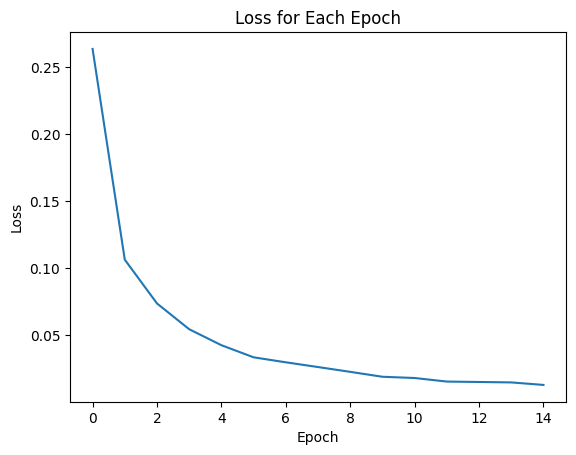

In [ ]:
lossMultiLayer, accuracyMultiLayer, epochLossMultiLayer, predictLabelsMultiLayer = multiLayerPerceptron(trainingData, trainingLabels, testingData, testingLabels, numClasses, 15)

# Plot epoch loss graph to find optimal number of epoch
epoch_plot_loss(epochLossMultiLayer)

Epoch 1/5
1688/1688 [==============================] - 11s 6ms/step - loss: 0.2730 - accuracy: 0.9176 - val_loss: 0.1140 - val_accuracy: 0.9667
Epoch 2/5
1688/1688 [==============================] - 8s 5ms/step - loss: 0.1075 - accuracy: 0.9665 - val_loss: 0.1079 - val_accuracy: 0.9652
Epoch 3/5
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0714 - accuracy: 0.9777 - val_loss: 0.0805 - val_accuracy: 0.9765
Epoch 4/5
1688/1688 [==============================] - 10s 6ms/step - loss: 0.0548 - accuracy: 0.9833 - val_loss: 0.0787 - val_accuracy: 0.9762
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.0889 - accuracy: 0.9738


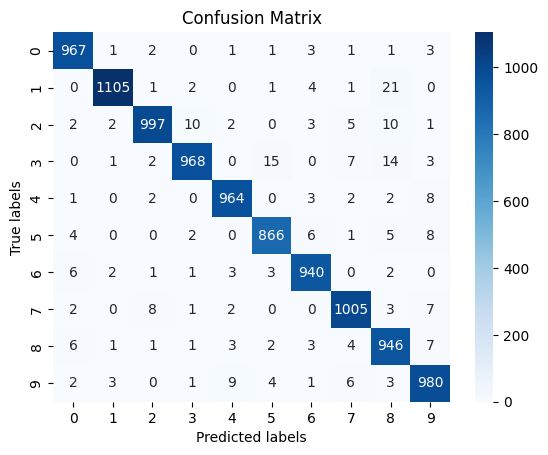

In [ ]:
optimalEpochNumMultiLayer = 5
# train the model using the optimal number of epoch
lossMultiLayerOptimal, accuracyMultiLayerOptimal, epochLossMultiLayerOptimal, predictLabelsMultiLayerOptimal = multiLayerPerceptron(trainingData, trainingLabels, testingData, testingLabels, numClasses, optimalEpochNumMultiLayer)

# make confusion matrix based on the predictions of One Layer Perceptron
makeConfusionMatrix(testingLabels, predictLabelsMultiLayerOptimal)

The convolutionalNetwork implements CNN model.

In [ ]:
def convolutionalNetwork(trainingData, trainingLabels, testingData, testingLabels, imageSize, numClasses, epochsNum):
  '''
  The function implements Convolutional Neural Networks.
  PARAMETERS:
  trainingData - a 2D numpy array contains the training samples
  trainingLabels -  a 1D numpy array contains the labels of training samples
  testingData - a 2D numpy array contains the testing samples
  testingLabels -  a 1D numpy array contains the labels of testing samples
  imageSize - an integer value indicating the dimension of a sample image
  numClasses - an integer value indicating the number of classes (1 class for each digit)

  RETURN VALUE: loss, accuracy
  The function returns loss (a scaler value of categorical cross entropy) and accuracy (the
  pecentage of predict values that match with actual values)
  '''
  #reshape the data to work with CNN
  trainingData = np.array(trainingData).reshape(-1, imageSize, imageSize, 1) #increasing 1 dimension for kernel operation
  testingData= np.array(testingData).reshape(-1, imageSize, imageSize, 1)

  model = Sequential([
    Conv2D(64, (3,3), activation='relu', input_shape=(imageSize, imageSize, 1)),  # First convolutional layer with 32 filters and 3x3 kernel
    MaxPooling2D((2,2)),  # First max pooling layer with 2x2 pool size
    Conv2D(64, (3,3), activation='relu'),  # Second convolutional layer with 64 filters and 3x3 kernel
    MaxPooling2D((2,2)),  # Second max pooling layer with 2x2 pool size
    Conv2D(64, (3,3), activation='relu'),  # Third convolutional layer with 128 filters and 3x3 kernel
    Flatten(),  # Flatten the output of the third convolutional layer
    Dense(32, activation='relu'),  # First fully connected layer with 128 neurons and ReLU activation
    Dense(numClasses, activation='softmax')  # Output layer with 10 neurons (one for each digit) and softmax activation
  ])
  model.compile(loss = "sparse_categorical_crossentropy", optimizer ="adam", metrics =['accuracy'])
  history = model.fit(trainingData, trainingLabels, epochs= epochsNum, validation_split=0.1)
  epochAccuracy = history.history['accuracy']
  epochLoss = history.history['loss']
  loss, accuracy = model.evaluate(testingData, testingLabels)
  ynew = model.predict(testingData)
  predictLabels  = np.argmax(ynew,axis = 1)
  return loss, accuracy, epochLoss, predictLabels

Epoch 1/15
1688/1688 [==============================] - 87s 51ms/step - loss: 0.1925 - accuracy: 0.9415 - val_loss: 0.0748 - val_accuracy: 0.9790
Epoch 2/15
1688/1688 [==============================] - 93s 55ms/step - loss: 0.0610 - accuracy: 0.9811 - val_loss: 0.0416 - val_accuracy: 0.9873
Epoch 3/15
1688/1688 [==============================] - 85s 50ms/step - loss: 0.0412 - accuracy: 0.9870 - val_loss: 0.0484 - val_accuracy: 0.9847
Epoch 4/15
1688/1688 [==============================] - 84s 50ms/step - loss: 0.0314 - accuracy: 0.9903 - val_loss: 0.0460 - val_accuracy: 0.9863
Epoch 5/15
1688/1688 [==============================] - 85s 50ms/step - loss: 0.0245 - accuracy: 0.9920 - val_loss: 0.0304 - val_accuracy: 0.9918
Epoch 6/15
1688/1688 [==============================] - 97s 57ms/step - loss: 0.0199 - accuracy: 0.9935 - val_loss: 0.0381 - val_accuracy: 0.9897
Epoch 7/15
1688/1688 [==============================] - 88s 52ms/step - loss: 0.0158 - accuracy: 0.9948 - val_loss: 0.0449 -

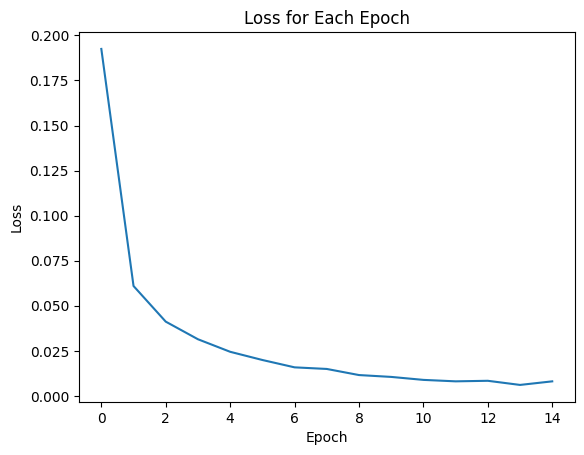

In [ ]:
lossCnn, accuracyCnn, epochLossCnn, predictLabelsCnn = convolutionalNetwork(trainingData, trainingLabels, testingData, testingLabels, imageSize, numClasses, 15)

# Plot epoch loss graph to find optimal number of epoch
epoch_plot_loss(epochLossCnn)

Epoch 1/5
1688/1688 [==============================] - 86s 50ms/step - loss: 0.1912 - accuracy: 0.9402 - val_loss: 0.0736 - val_accuracy: 0.9772
Epoch 2/5
1688/1688 [==============================] - 84s 50ms/step - loss: 0.0603 - accuracy: 0.9811 - val_loss: 0.0408 - val_accuracy: 0.9873
Epoch 3/5
1688/1688 [==============================] - 85s 50ms/step - loss: 0.0412 - accuracy: 0.9870 - val_loss: 0.0369 - val_accuracy: 0.9882
Epoch 4/5
1688/1688 [==============================] - 83s 49ms/step - loss: 0.0321 - accuracy: 0.9903 - val_loss: 0.0318 - val_accuracy: 0.9915
Epoch 5/5
313/313 [==============================] - 4s 12ms/step


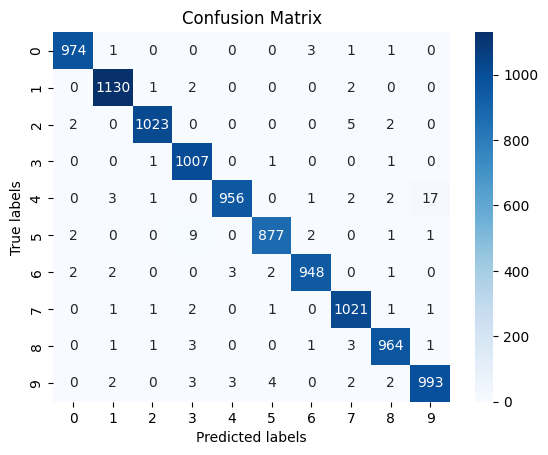

In [ ]:
optimalEpochNumCnn = 5
# train the model using the optimal number of epoch
lossCnnOptimal, accuracyCnnOptimal, epochLossCnnOptimal, predictLabelsCnnOptimal = convolutionalNetwork(trainingData, trainingLabels, testingData, testingLabels, imageSize, numClasses, optimalEpochNumCnn)

# make confusion matrix based on the predictions of One Layer Perceptron
makeConfusionMatrix(testingLabels, predictLabelsCnnOptimal)